Use fancy machine learning to predict whether an article makes it into Nature/Science or PRL. This time we'll only look at articles in the physics.atom-ph section.

In [41]:
#Need to add parent directoy to sys.path to find 'metadataDB'
import sys
sys.path.append('../../')

%matplotlib inline
import matplotlib.pyplot as plt 
import time
import numpy as np
import re
import json

# Natural language processing toolkit
# To use this, run nltk.download() and download 'stopwords'
# from nltk.corpus import stopwords
# s=stopwords.words('english') + ['']

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.cross_validation import train_test_split

# SQL
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from metadataDB.declareDatabase import *
from sqlalchemy import or_, and_

engine = create_engine("sqlite:///../../arXiv_metadata.db", echo=False)
Base.metadata.bind = engine
DBsession = sessionmaker(bind=engine)
session = DBsession()

In [2]:
# categories = ['atom-ph', 'quant-ph', 'cond-mat', 'quant-gas', 'hep-th', 'hep-ex', '']
category = ['quant-ph']
journals_dict = {'PRL': ['Physics Review Letters%',
                    'Phys. Rev. Lett.%',
                    'Phys.Rev.Lett.%',
                    'PRL%'],
                 'PR':  ['Physics Review%',
                         'Phys. Rev.%',
                         'Phys.Rev.%',
                         'PR%'],
                 'Nature': ['Nature%',
                            'Nat.%',
                            'Science%'],
                 'APL': ['APL%',
                         'Appl.Phys.Lett.%',
                         'Appl. Phys. Lett.%',
                         'Applied Physics Letters%'],
                 'AP': ['AP%',
                        'Appl.Phys.%',
                        'Appl. Phys.%',
                        'Applied Physics%'],
                 'All': ['%'],
                 }


In [3]:
def get_abstracts(journal, category):
    query = session.query(Article_Category)\
                    .join(Category)\
                    .join(Article)\
                    .filter(Category.name.like('%' + category + '%'),
                            or_(*[Article.journal_ref.like(x) for x in journals_dict[journal]]))

    # Don't need to clean up text: CountVectorizer will do everything
    return [ result.article.abstract for result in query ]

    
    
# def cleanup_text(paragraph):
#     return [ x for x in re.sub('[^a-z ]', '',
#                                re.sub('[\n]', ' ', paragraph.lower().strip())).split()
#             if x  not in s ]




In [4]:
abstracts1 = get_abstracts('PRL' ,'cond-mat')
abstracts2 = get_abstracts('Nature' ,'cond-mat')
print len(abstracts1)
print len(abstracts2)

15834
3087


In [5]:
print len(abstracts1)
print len(abstracts2)

half_test_size = int(round(0.2*min(len(abstracts1),len(abstracts2))))

X1_train, X1_test, y1_train, y1_test = train_test_split(abstracts1, [0]*len(abstracts1), test_size=half_test_size, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(abstracts2, [1]*len(abstracts2), test_size=half_test_size, random_state=42)

X_train = X1_train + X2_train
X_test = X1_test + X2_test
y_train = np.array(y1_train + y2_train)
y_test = np.array(y1_test + y2_test)
target_names = ['PRL', 'Nature']

# print len(y_test)
# print y_test

15834
3087


In [6]:
session.close_all()

In [ ]:
# #SVC(kernel='linear') is good
# clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,3))),
#                 ('tfidf', TfidfTransformer()),
#                 ('clf', LinearSVC(C=1,penalty='l1',dual=False,fit_intercept=True))])
# transform = clf.fit_transform(X_train, y_train)
# tfidf = clf.named_steps['tfidf'].transform(clf.named_steps['vect'].transform(X_train))
# transform2 = clf.named_steps['tfidf'].transform(tfidf)

# y_predict_train = clf.predict(X_train)
# y_predict_test = clf.predict(X_test)
# # print text_abstract_clf.predict(X_train)
# print transform.shape

In [29]:
vect = CountVectorizer(ngram_range=(1,3))
X_train_vect = vect.fit_transform(X_train)
print X_train_vect.shape

tfidf =  TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_vect)
print X_train_tfidf.shape
clf = LinearSVC(C=1,penalty='l1',dual=False,fit_intercept=False)
transform = clf.fit_transform(X_train_tfidf, y_train)
print transform.shape

y_predict_train = clf.predict(tfidf.transform(vect.transform(X_train)))
y_predict_test = clf.predict(tfidf.transform(vect.transform(X_test)))

(17687, 1318721)
(17687, 1318721)
(17687, 1189)


In [30]:
#SVC(kernel='linear')
print(metrics.classification_report(y_test, y_predict_test,
                                    target_names=target_names))
#                                     target_names=test_target_names))
print metrics.confusion_matrix(y_test, y_predict_test)
print metrics.accuracy_score(y_test, y_predict_test)

             precision    recall  f1-score   support

        PRL       0.71      0.98      0.82       617
     Nature       0.96      0.61      0.74       617

avg / total       0.84      0.79      0.78      1234

[[602  15]
 [242 375]]
0.791734197731


In [31]:
most_important_words = clf.coef_.argsort()[:, ::-1]

terms =  vect.get_feature_names()
print ', '.join([terms[x] for x in most_important_words[0, :20]])
print ', '.join([terms[x] for x in most_important_words[0, -20:]])
# for i in range(len(category_list)):
#     print "Category %s:" % (category_list[i])
#     print ', '.join([terms[x] for x in most_important_words[i, :20]])
#     print ''

here we, challenge, here we report, here, temperature superconductivity, is fundamental, here we demonstrate, experiment we, here we address, however, microscopy we, research, crystallographic, for example, here we use, elusive, pairing gap, yet, central, helices
we consider, is, first principles, investigate, thermoelectric materials, show, calculate, phys rev, calculations, we study, 3d dirac points, behavior, mesoscopic, present, model, comment, simulations, investigated, propose, we


In [33]:
# phrase1 = 'here we'
# phrase2 = 'temperature superconductivity'
phrase1 = 'here we'
phrase2 = 'temperature superconductivity'
phrase1_index = vect.vocabulary_[phrase1]
phrase2_index = vect.vocabulary_[phrase2]
print phrase1_index

try:
    a0 = clf.intercept_[0]
except:
    a0 = 0
a1 = clf.coef_[0,phrase1_index]
a2 = clf.coef_[0,phrase2_index]
print (a0, a1, a2)

500922
(0, 15.670785138941246, 8.4924157001429599)


In [34]:
# Each article gives one point on a plot of x1=phrase1 vs x2=phrase2

x1 = np.squeeze(X_train_tfidf[:, phrase1_index].toarray())
x2 = np.squeeze(X_train_tfidf[:, phrase2_index].toarray())

In [35]:
# The intercept on the 2D plot is NOT given by a0, but depends on the mean value of
# (coefficient matrix) * (typical tfidf) for the rest of the terms.

tfidf_mean = np.squeeze(np.asarray(X_train_tfidf.mean(axis=0)))
# print tfidf_mean.shape
# print clf.named_steps['clf'].coef_[0,:].shape
tfidf_weighted = clf.coef_[0,:] * np.array(X_train_tfidf.mean(axis=0))[0,:]
print tfidf_weighted.shape
print tfidf_weighted.sum()

(1318721,)
-0.901512122072


In [36]:
# I'm confused by the plots. Let's also run LinearSVC on just the two dimensional dataset.
clf_2d = LinearSVC(C=1,penalty='l1',dual=False,fit_intercept=True)
clf_2d.fit(np.vstack((x1,x2)).T, y_train)
a0_2d = clf_2d.intercept_[0]
a1_2d = clf_2d.coef_[0,0]
a2_2d = clf_2d.coef_[0,1]
print (a0_2d, a1_2d, a2_2d)

(-0.85863654565121816, 49.588306334106854, 21.440959653655042)


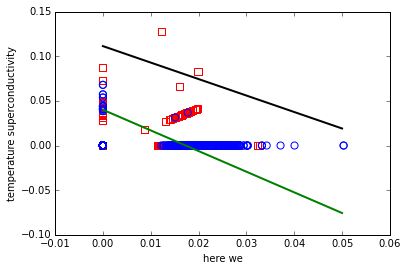

In [37]:
x1_line = np.linspace(0, 0.05)
a0b = (a0 # Is the factor of 1/2 real or a coincidence?
      + tfidf_weighted.sum()
      - tfidf_weighted[phrase1_index]
      - tfidf_weighted[phrase2_index])
# print (a0, tfidf_weighted.sum(), tfidf_weighted[phrase1_index], tfidf_weighted[phrase2_index])
# # a0b = -0.15 # -0.2 is pretty good
# a0b = -0.2
x2_line = -(a0b + a1*x1_line) / a2
x2_line_2d = -(a0_2d + a1_2d*x1_line) / a2_2d
# # m = np.array(['s', 'o']
plt.plot(x1_line, x2_line, 'k', lw=2)
plt.plot(x1_line, x2_line_2d, 'g', lw=2)
# # plt.scatter(x1, x2, c='blue', marker='o', s=50.*(y_predict_train))
# # plt.scatter(x1, x2, c='red', marker='s', s=50.*(1-y_predict_train))
plt.scatter(x1[y_train==1],
            x2[y_train==1],
            facecolor='None',
            edgecolor='red',
            marker='s', s=50)
plt.scatter(x1[y_train==0],
            x2[y_train==0],
            facecolor='None',
            edgecolor='blue',
            marker='o', s=50)

# plt.scatter(x1, x2, c='red', marker='s', s=50.*(1-y_test))
plt.xlabel(phrase1)
plt.ylabel(phrase2)

In [44]:
result = {'name': terms[x], 'value': np.squeeze(X_train_tfidf[:, phrase1_index].toarray())}
print json.dumps({'name': phrase1, 'value': x1.tolist()}, {'name': phrase2, 'value': x2.tolist()})

{"name": "here we", "value": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021230579903442556, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02015413246336321, 0.0, 0.0, 0.019636560681581365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023726667681189514, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01868828204400637, 0.0, 0.0, 0.020627566375834537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0172223978877812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

# 1D plot

In many ways, the 1D plot is more clear.

-0.0173153029238
-0.271344391734
(0, -0.94557849775570058)


(-1, 1)

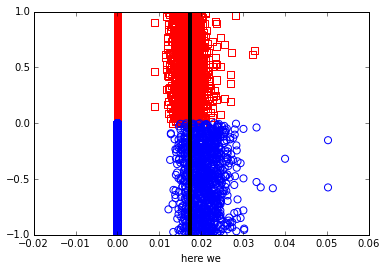

In [38]:
plt.scatter(x1[y_train==1],
            np.random.rand(x1[y_train==1].size),
            facecolor='None',
            edgecolor='red',
            marker='s', s=50)
plt.scatter(x1[y_train==0],
            -np.random.rand(x1[y_train==0].size),
            facecolor='None',
            edgecolor='blue',
            marker='o', s=50)

plt.plot((-a0_2d/a1_2d)*np.array([1, 1]), [-1, 1],
         'k',
         lw=4,)

print (a0_2d/a1_2d)
print (a0_2d/a1_2d) * a1
print (a0, a0b)

plt.xlabel(phrase1)
plt.ylim([-1, 1])


In [27]:
clf.C

1

In [39]:
0.271344391734/a0b

-0.28696125427770086